In [28]:
import astropy.units as u
import astropy.constants as const
from tdsat_telescope import load_telescope_parameters
from tdsat_sensitivity import src_rate, bgd_sky_qe_rate, bgd_electronics, calc_exposure, calc_snr
from tdsat_neff import get_neff
from bbmag import bb_abmag_fluence, bb_abmag
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table

from astropy.visualization import quantity_support
import matplotlib
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [2]:
plt.rcParams['figure.figsize'] = [12,8]

In [3]:
read_noise = 3.*(2**0.5) # Read noise for two frames

point_drift = 1*u.arcsec # To be added to the PSF in quadrature
point_jitter = 5*u.arcsec
# Define bands
td1_band = [193, 233]*u.nm


# Transmission efficiency
trans_eff = (0.975)**8 # from Jim. 

print('Transmission efficiency: {}'.format(trans_eff))

# Load telescope info
config=11
diameter, qe, psf_size, pixel_size, efficiency = load_telescope_parameters(config)

area = np.pi * (diameter*0.5)**2
area_onaxis = np.pi * (0.5*24.2*u.cm)**2
efficiency = area_onaxis / area

print('Effective area (used) {}'.format(area*efficiency))



# Add in fuzz...
psf_size = (psf_size**2 + point_drift**2 + point_jitter**2)**0.5


print('Effective PSF size {}'.format(psf_size))
# Get the number of effective background pixels
neff = get_neff(psf_size, pixel_size)
print('Number of effective bgd pixels: {}'.format(neff))
print()



Transmission efficiency: 0.8166518036622619
Telescope Configuration 11
Name: Small Focal Plane CMOS
Entrance Pupil diameter 26.0 cm
Optical Efficiency 0.7893639053254439
PSF FWHM 4.288 arcsec
Pixel size 6.4 arcsec
Effective Aperture 23.1 cm
Effective Area 419.09631397051237 cm2
Effective area (used) 459.9605804120816 cm2
Effective PSF size 6.6623527375845235 arcsec
Number of effective bgd pixels: 2.990374488245114



In [4]:
light=True
texp = 300*u.s
# Compute sky background
bgd_ph_rate = bgd_sky_qe_rate(low_zodi=True,
                              diameter=diameter,
                              pixel_size=pixel_size, real_red=True, light=light)
bgd_band1 = trans_eff * efficiency * bgd_ph_rate
print('Sky background rate per pixel band1: {}'.format(bgd_band1))

bgd_ph_rate = bgd_sky_qe_rate(low_zodi=True,
                              diameter=diameter,
                              qe_band=2,
                              pixel_size=pixel_size, real_red=True, light=light)
bgd_band2 = trans_eff  * efficiency * bgd_ph_rate
print('Sky background rate per pixel band2: {}'.format(bgd_band2))


center = 208
width = 53
bandone=[center - 0.5*width, center+0.5*width]*u.nm

center = 284
width = 68
bandtwo=[center - 0.5*width, center+0.5*width]*u.nm

dist0 = 10*u.pc

/Users/mheida/software/miniconda2/envs/envpy3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Sky background rate per pixel band1: 0.030369732491096913 1 / s
Sky background rate per pixel band2: 0.2478588509265617 1 / s


In [5]:
# Load Tony's lightcurves
iib_rad = np.loadtxt('input_data/IIb_radius.txt')
iib_tef = np.loadtxt('input_data/IIb_teff.txt')
iip_big_rad = np.loadtxt('input_data/IIp_big_radius.txt')
iip_big_tef = np.loadtxt('input_data/IIp_big_teff.txt')
iip_rad = np.loadtxt('input_data/IIp_radius.txt')
iip_tef = np.loadtxt('input_data/IIp_teff.txt')
stripped_rad = np.loadtxt('input_data/stripped_radius.txt')
stripped_tef = np.loadtxt('input_data/stripped_teff.txt')

In [103]:
# Calculate time vs absolute magnitude and incident photon flux in DUET bands for all four models

iib_lc = Table([iib_tef[:,0]*u.s,np.zeros(len(iib_tef))*u.ABmag,np.zeros(len(iib_tef))*u.ABmag,np.zeros(len(iib_tef))*1/(u.s*u.cm**2),np.zeros(len(iib_tef))*1/(u.s*u.cm**2)],
               names=('Time', 'mag_D1', 'mag_D2', 'photflux_D1', 'photflux_D2'), meta={'name': 'SNIIb - mags and photon flux at 10pc'})
for i in range(len(iib_tef)):
    bolflux = (iib_tef[i,1]*u.K)**4 * const.sigma_sb.cgs * ((iib_rad[i,1]*u.cm)/dist0.to(u.cm))**2
    band1_fluence, band2_fluence = bb_abmag_fluence(bbtemp=iib_tef[i,1]*u.K, bolflux=bolflux, light=light)
    band1_mag, band2_mag = bb_abmag(bbtemp=iib_tef[i,1]*u.K, bandone=bandone, 
                                  bandtwo=bandtwo, bolflux=bolflux, val=True)
    iib_lc[i]['mag_D1'],iib_lc[i]['mag_D2'] = band1_mag,band2_mag
    iib_lc[i]['photflux_D1'],iib_lc[i]['photflux_D2'] = band1_fluence.value,band2_fluence.value
    
iip_lc = Table([iip_tef[:,0]*u.s,np.zeros(len(iip_tef))*u.ABmag,np.zeros(len(iip_tef))*u.ABmag,np.zeros(len(iip_tef))*1/(u.s*u.cm**2),np.zeros(len(iip_tef))*1/(u.s*u.cm**2)],
               names=('Time', 'mag_D1', 'mag_D2', 'photflux_D1', 'photflux_D2'), meta={'name': 'SNIIp - mags and photon flux at 10pc'})
for i in range(len(iip_tef)):
    bolflux = (iip_tef[i,1]*u.K)**4 * const.sigma_sb.cgs * ((iip_rad[i,1]*u.cm)/dist0.to(u.cm))**2
    band1_fluence, band2_fluence = bb_abmag_fluence(bbtemp=iip_tef[i,1]*u.K, bolflux=bolflux, light=light)
    band1_mag, band2_mag = bb_abmag(bbtemp=iip_tef[i,1]*u.K, bandone=bandone, 
                                  bandtwo=bandtwo, bolflux=bolflux, val=True)
    iip_lc[i]['mag_D1'],iip_lc[i]['mag_D2'] = band1_mag,band2_mag
    iip_lc[i]['photflux_D1'],iip_lc[i]['photflux_D2'] = band1_fluence.value ,band2_fluence.value

iip_big_lc = Table([iip_big_tef[:,0]*u.s,np.zeros(len(iip_big_tef))*u.ABmag,np.zeros(len(iip_big_tef))*u.ABmag,np.zeros(len(iip_big_tef))*1/(u.s*u.cm**2),np.zeros(len(iip_big_tef))*1/(u.s*u.cm**2)],
               names=('Time', 'mag_D1', 'mag_D2', 'photflux_D1', 'photflux_D2'), meta={'name': 'SNIIp, large radius - mags and photon flux at 10pc'})
for i in range(len(iip_big_tef)):
    bolflux = (iip_big_tef[i,1]*u.K)**4 * const.sigma_sb.cgs * ((iip_big_rad[i,1]*u.cm)/dist0.to(u.cm))**2
    band1_fluence, band2_fluence = bb_abmag_fluence(bbtemp=iip_big_tef[i,1]*u.K, bolflux=bolflux, light=light)
    band1_mag, band2_mag = bb_abmag(bbtemp=iip_big_tef[i,1]*u.K, bandone=bandone, 
                                  bandtwo=bandtwo, bolflux=bolflux, val=True)
    iip_big_lc[i]['mag_D1'],iip_big_lc[i]['mag_D2'] = band1_mag,band2_mag
    iip_big_lc[i]['photflux_D1'],iip_big_lc[i]['photflux_D2'] = band1_fluence.value ,band2_fluence.value
    
stripped_lc = Table([stripped_tef[:,0]*u.s,np.zeros(len(stripped_tef))*u.ABmag,np.zeros(len(stripped_tef))*u.ABmag,np.zeros(len(stripped_tef))*1/(u.s*u.cm**2),np.zeros(len(stripped_tef))*1/(u.s*u.cm**2)],
               names=('Time', 'mag_D1', 'mag_D2', 'photflux_D1', 'photflux_D2'), meta={'name': 'Hydrogen stripped SN - mags and photon flux at 10pc'})
for i in range(len(stripped_tef)):
    bolflux = (stripped_tef[i,1]*u.K)**4 * const.sigma_sb.cgs * ((stripped_rad[i,1]*u.cm)/dist0.to(u.cm))**2
    band1_fluence, band2_fluence = bb_abmag_fluence(bbtemp=stripped_tef[i,1]*u.K, bolflux=bolflux, light=light)
    band1_mag, band2_mag = bb_abmag(bbtemp=stripped_tef[i,1]*u.K, bandone=bandone, 
                                  bandtwo=bandtwo, bolflux=bolflux, val=True)
    stripped_lc[i]['mag_D1'],stripped_lc[i]['mag_D2'] = band1_mag,band2_mag
    stripped_lc[i]['photflux_D1'],stripped_lc[i]['photflux_D2'] = band1_fluence.value ,band2_fluence.value


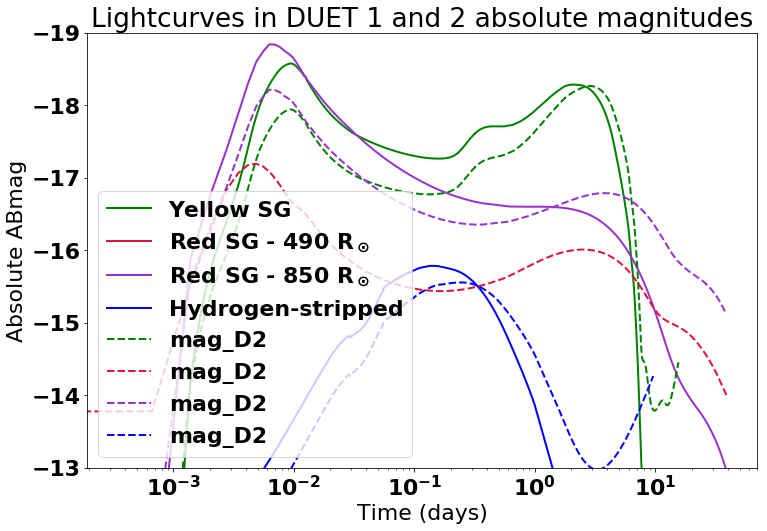

In [79]:
plt.plot((iib_lc['Time']-iib_lc['Time'][0]).to(u.day),iib_lc['mag_D1'],linewidth=2,color='green',label='Yellow SG')
plt.plot((iip_lc['Time']-iip_lc['Time']-3000).to(u.day),iip_lc['mag_D1'],linewidth=2,color='crimson',label=r'Red SG - 490 R$_\odot$')
plt.plot((iip_big_lc['Time']-iip_big_lc['Time'][0]).to(u.day),iip_big_lc['mag_D1'],linewidth=2,color='darkorchid',label=r'Red SG - 850 R$_\odot$')
plt.plot((stripped_lc['Time']-stripped_lc['Time'][0]).to(u.day),stripped_lc['mag_D1'],linewidth=2,color='blue',label='Hydrogen-stripped')
plt.plot((iib_lc['Time']-iib_lc['Time'][0]).to(u.day),iib_lc['mag_D2'],linewidth=2,color='green',linestyle='--')
plt.plot((iip_lc['Time']-iip_lc['Time'][0]-3000).to(u.day),iip_lc['mag_D2'],linewidth=2,color='crimson',linestyle='--')
plt.plot((iip_big_lc['Time']-iip_big_lc['Time'][0]).to(u.day),iip_big_lc['mag_D2'],color='darkorchid',linewidth=2,linestyle='--')
plt.plot((stripped_lc['Time']-stripped_lc['Time'][0]).to(u.day),stripped_lc['mag_D2'],linewidth=2,color='blue',linestyle='--')

plt.legend()
plt.ylim(-13.,-19.)
plt.xscale('log')
#plt.xlim(0,1)
plt.title('Lightcurves in DUET 1 and 2 absolute magnitudes')
plt.xlabel('Time (days)')
plt.ylabel('Absolute ABmag')
plt.show()

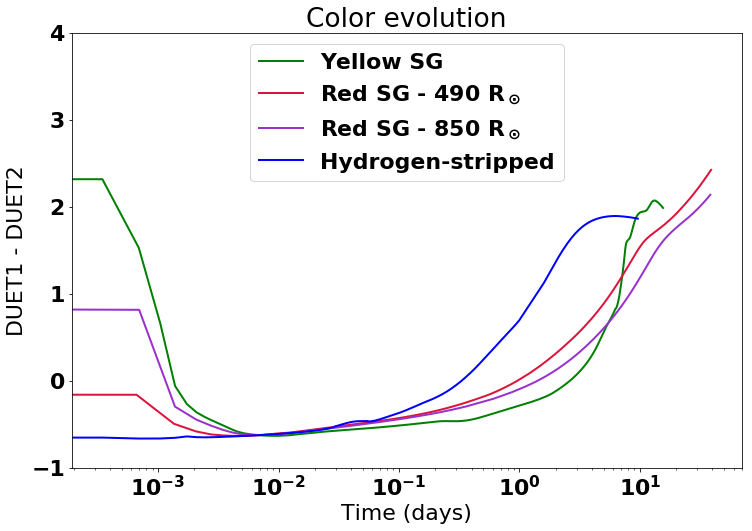

In [78]:
plt.plot((iib_lc['Time']-iib_lc['Time'][0]).to(u.day),iib_lc['mag_D1']-iib_lc['mag_D2'],linewidth=2,color='green',label='Yellow SG')
plt.plot((iip_lc['Time']-iip_lc['Time'][0]-3000).to(u.day),iip_lc['mag_D1']-iip_lc['mag_D2'],linewidth=2,color='crimson',label=r'Red SG - 490 R$_\odot$')
plt.plot((iip_big_lc['Time']-iip_big_lc['Time'][0]).to(u.day),iip_big_lc['mag_D1']-iip_big_lc['mag_D2'],linewidth=2,color='darkorchid',label=r'Red SG - 850 R$_\odot$')
plt.plot((stripped_lc['Time']-stripped_lc['Time'][0]).to(u.day),stripped_lc['mag_D1']-stripped_lc['mag_D2'],linewidth=2,color='blue',label='Hydrogen-stripped')

plt.legend()
plt.ylim(-1.,4)
plt.xscale('log')
plt.title('Color evolution')
plt.xlabel('Time (days)')
plt.ylabel('DUET1 - DUET2')
plt.show()

In [106]:
# Calculate S/N in a single 300 s exposure at 50, 200, 500 Mpc
distance = [50,200,500]*u.Mpc

iib_snr = np.zeros([len(iib_tef),(1+len(distance))*2])
iib_snr[:,0:2] = iib_tef
for j, dist in enumerate(distance):
    for i in range(len(iib_tef)):
        band1_fluence = iib_lc['photflux_D1'].quantity[i]*(dist0.to(u.pc)/dist.to(u.pc))**2
        band2_fluence = iib_lc['photflux_D2'].quantity[i]*(dist0.to(u.pc)/dist.to(u.pc))**2
        band1_rate = trans_eff * efficiency * area * band1_fluence
        band2_rate = trans_eff * efficiency * area * band2_fluence
        snr1 = calc_snr(texp, band1_rate, bgd_band1, read_noise, neff)
        snr2 = calc_snr(texp, band2_rate, bgd_band2, read_noise, neff)
        iib_snr[i,2+j*2:4+j*2] = snr1,snr2

iip_snr = np.zeros([len(iip_tef),(1+len(distance))*2])
iip_snr[:,0:2] = iip_tef
for j, dist in enumerate(distance):
    for i in range(len(iip_tef)):
        band1_fluence = iip_lc['photflux_D1'].quantity[i]*(dist0.to(u.pc)/dist.to(u.pc))**2
        band2_fluence = iip_lc['photflux_D2'].quantity[i]*(dist0.to(u.pc)/dist.to(u.pc))**2
        band1_rate = trans_eff * efficiency * area * band1_fluence
        band2_rate = trans_eff * efficiency * area * band2_fluence
        snr1 = calc_snr(texp, band1_rate, bgd_band1, read_noise, neff)
        snr2 = calc_snr(texp, band2_rate, bgd_band2, read_noise, neff)
        iip_snr[i,2+j*2:4+j*2] = snr1,snr2

iip_big_snr = np.zeros([len(iip_big_tef),(1+len(distance))*2])
iip_big_snr[:,0:2] = iip_big_tef
for j, dist in enumerate(distance):
    for i in range(len(iip_big_tef)):
        band1_fluence = iip_big_lc['photflux_D1'].quantity[i]*(dist0.to(u.pc)/dist.to(u.pc))**2
        band2_fluence = iip_big_lc['photflux_D2'].quantity[i]*(dist0.to(u.pc)/dist.to(u.pc))**2
        band1_rate = trans_eff * efficiency * area * band1_fluence
        band2_rate = trans_eff * efficiency * area * band2_fluence
        snr1 = calc_snr(texp, band1_rate, bgd_band1, read_noise, neff)
        snr2 = calc_snr(texp, band2_rate, bgd_band2, read_noise, neff)
        iip_big_snr[i,2+j*2:4+j*2] = snr1,snr2

stripped_snr = np.zeros([len(stripped_tef),(1+len(distance))*2])
stripped_snr[:,0:2] = stripped_tef
for j, dist in enumerate(distance):
    for i in range(len(stripped_tef)):
        band1_fluence = stripped_lc['photflux_D1'].quantity[i]*(dist0.to(u.pc)/dist.to(u.pc))**2
        band2_fluence = stripped_lc['photflux_D2'].quantity[i]*(dist0.to(u.pc)/dist.to(u.pc))**2
        band1_rate = trans_eff * efficiency * area * band1_fluence
        band2_rate = trans_eff * efficiency * area * band2_fluence
        snr1 = calc_snr(texp, band1_rate, bgd_band1, read_noise, neff)
        snr2 = calc_snr(texp, band2_rate, bgd_band2, read_noise, neff)
        stripped_snr[i,2+j*2:4+j*2] = snr1,snr2

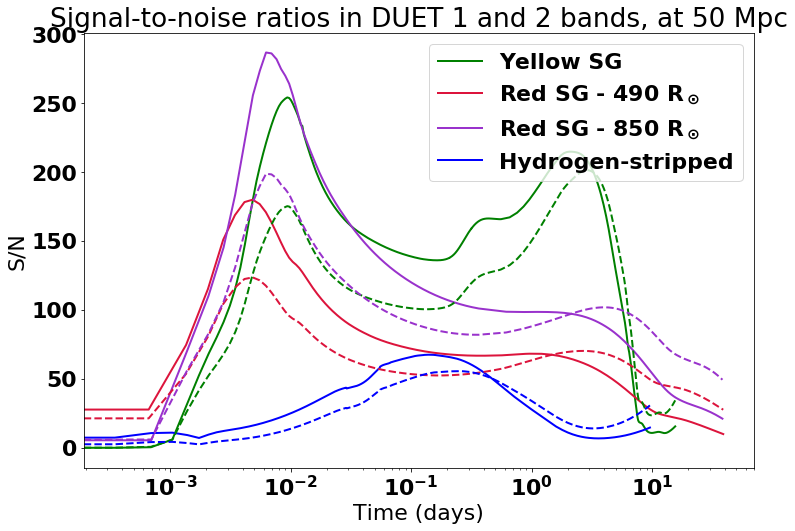

In [91]:
plt.plot((iib_snr[:,0]-iib_snr[0,0])/(3600*24),iib_snr[:,2],linewidth=2,color='green',label='Yellow SG')
plt.plot((iip_snr[:,0]-iip_snr[0,0]-3000)/(3600*24),iip_snr[:,2],linewidth=2,color='crimson',label=r'Red SG - 490 R$_\odot$')
plt.plot((iip_big_snr[:,0]-iip_big_snr[0,0])/(3600*24),iip_big_snr[:,2],linewidth=2,color='darkorchid',label=r'Red SG - 850 R$_\odot$')
plt.plot((stripped_snr[:,0]-stripped_snr[0,0])/(3600*24),stripped_snr[:,2],linewidth=2,color='blue',label='Hydrogen-stripped')
plt.plot((iib_snr[:,0]-iib_snr[0,0])/(3600*24),iib_snr[:,3],linewidth=2,color='green',linestyle='--')
plt.plot((iip_snr[:,0]-iip_snr[0,0]-3000)/(3600*24),iip_snr[:,3],linewidth=2,color='crimson',linestyle='--')
plt.plot((iip_big_snr[:,0]-iip_big_snr[0,0])/(3600*24),iip_big_snr[:,3],color='darkorchid',linewidth=2,linestyle='--')
plt.plot((stripped_snr[:,0]-stripped_snr[0,0])/(3600*24),stripped_snr[:,3],linewidth=2,color='blue',linestyle='--')

plt.legend()
#plt.ylim(-13.,-19.)
plt.xscale('log')
plt.title('Signal-to-noise ratios in DUET 1 and 2 bands, at 50 Mpc')
plt.xlabel('Time (days)')
plt.ylabel('S/N')
plt.show()

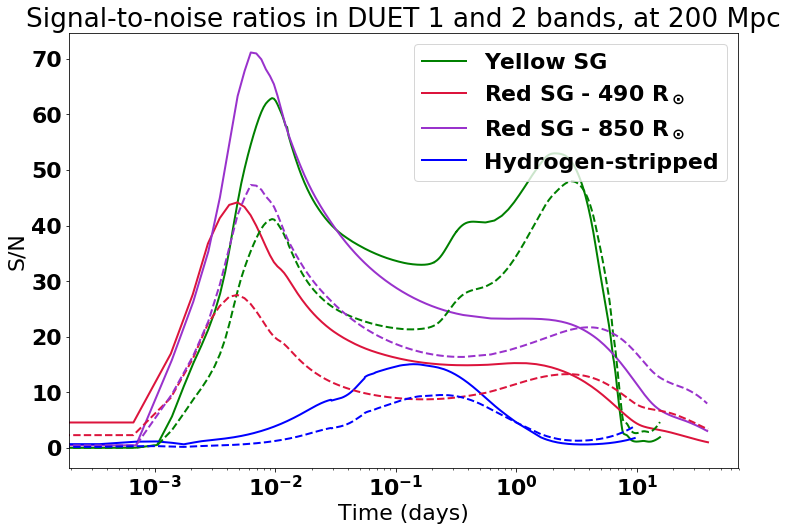

In [92]:
plt.plot((iib_snr[:,0]-iib_snr[0,0])/(3600*24),iib_snr[:,4],linewidth=2,color='green',label='Yellow SG')
plt.plot((iip_snr[:,0]-iip_snr[0,0]-3000)/(3600*24),iip_snr[:,4],linewidth=2,color='crimson',label=r'Red SG - 490 R$_\odot$')
plt.plot((iip_big_snr[:,0]-iip_big_snr[0,0])/(3600*24),iip_big_snr[:,4],linewidth=2,color='darkorchid',label=r'Red SG - 850 R$_\odot$')
plt.plot((stripped_snr[:,0]-stripped_snr[0,0])/(3600*24),stripped_snr[:,4],linewidth=2,color='blue',label='Hydrogen-stripped')
plt.plot((iib_snr[:,0]-iib_snr[0,0])/(3600*24),iib_snr[:,5],linewidth=2,color='green',linestyle='--')
plt.plot((iip_snr[:,0]-iip_snr[0,0]-3000)/(3600*24),iip_snr[:,5],linewidth=2,color='crimson',linestyle='--')
plt.plot((iip_big_snr[:,0]-iip_big_snr[0,0])/(3600*24),iip_big_snr[:,5],color='darkorchid',linewidth=2,linestyle='--')
plt.plot((stripped_snr[:,0]-stripped_snr[0,0])/(3600*24),stripped_snr[:,5],linewidth=2,color='blue',linestyle='--')

plt.legend()
#plt.ylim(-13.,-19.)
plt.xscale('log')
plt.title('Signal-to-noise ratios in DUET 1 and 2 bands, at 200 Mpc')
plt.xlabel('Time (days)')
plt.ylabel('S/N')
plt.show()

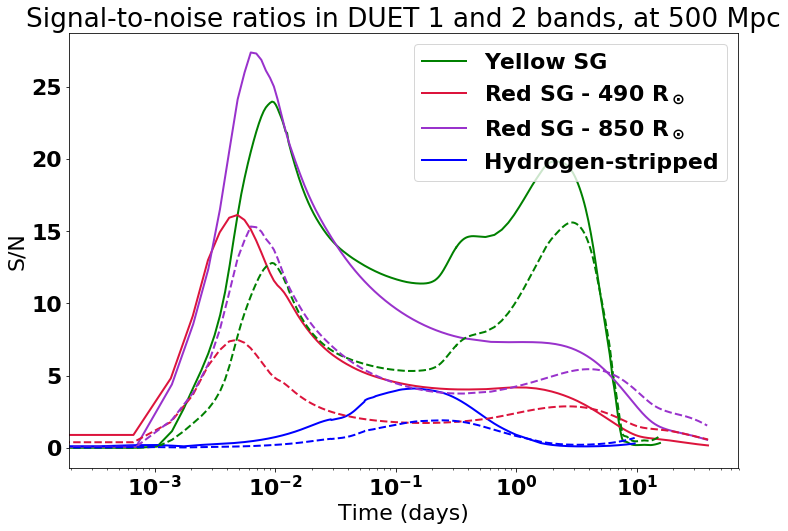

In [93]:
plt.plot((iib_snr[:,0]-iib_snr[0,0])/(3600*24),iib_snr[:,6],linewidth=2,color='green',label='Yellow SG')
plt.plot((iip_snr[:,0]-iip_snr[0,0]-3000)/(3600*24),iip_snr[:,6],linewidth=2,color='crimson',label=r'Red SG - 490 R$_\odot$')
plt.plot((iip_big_snr[:,0]-iip_big_snr[0,0])/(3600*24),iip_big_snr[:,6],linewidth=2,color='darkorchid',label=r'Red SG - 850 R$_\odot$')
plt.plot((stripped_snr[:,0]-stripped_snr[0,0])/(3600*24),stripped_snr[:,6],linewidth=2,color='blue',label='Hydrogen-stripped')
plt.plot((iib_snr[:,0]-iib_snr[0,0])/(3600*24),iib_snr[:,7],linewidth=2,color='green',linestyle='--')
plt.plot((iip_snr[:,0]-iip_snr[0,0]-3000)/(3600*24),iip_snr[:,7],linewidth=2,color='crimson',linestyle='--')
plt.plot((iip_big_snr[:,0]-iip_big_snr[0,0])/(3600*24),iip_big_snr[:,7],color='darkorchid',linewidth=2,linestyle='--')
plt.plot((stripped_snr[:,0]-stripped_snr[0,0])/(3600*24),stripped_snr[:,7],linewidth=2,color='blue',linestyle='--')

plt.legend()
#plt.ylim(-13.,-19.)
plt.xscale('log')
plt.title('Signal-to-noise ratios in DUET 1 and 2 bands, at 500 Mpc')
plt.xlabel('Time (days)')
plt.ylabel('S/N')
plt.show()

In [107]:
# Remove ABmag units, write to fits tables
iib_lc['mag_D1'].unit = None
iib_lc['mag_D2'].unit = None
iip_big_lc['mag_D1'].unit = None
iip_big_lc['mag_D2'].unit = None
iip_lc['mag_D1'].unit = None
iip_lc['mag_D2'].unit = None
stripped_lc['mag_D1'].unit = None
stripped_lc['mag_D2'].unit = None
iib_lc.write('SNIIb_lightcurve_DUET.fits', format='fits', overwrite=True)
iip_big_lc.write('SNIIp-large_lightcurve_DUET.fits', format='fits', overwrite=True)
iip_lc.write('SNIIp_lightcurve_DUET.fits', format='fits', overwrite=True)
stripped_lc.write('H-strippedSN_lightcurve_DUET.fits', format='fits', overwrite=True)
iib_lc['mag_D1'].unit = u.ABmag
iib_lc['mag_D2'].unit = u.ABmag
iip_big_lc['mag_D1'].unit = u.ABmag
iip_big_lc['mag_D2'].unit = u.ABmag
iip_lc['mag_D1'].unit = u.ABmag
iip_lc['mag_D2'].unit = u.ABmag
stripped_lc['mag_D1'].unit = u.ABmag
stripped_lc['mag_D2'].unit = u.ABmag